In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

In [2]:
# jedi 0.14.1 tab completion fails; will be fixed in 0.14.2
import jedi
if jedi.__version__ == '0.14.1':
    %config Completer.use_jedi = False
    
# Progress bar
from tqdm.auto import trange, tqdm

In [3]:
import pynrc
from pynrc import nrc_utils
from pynrc import nircam_dark
from pynrc.nrc_utils import S, source_spectrum, pad_or_cut_to_size

import webbpsf, os

from astropy.io import fits
import astropy.units as u

from scipy.interpolate import interp1d

pynrc.setup_logging('WARNING', verbose=False)

In [4]:
# Directory to save simulations
name_sci = 'GJ436'
outdir_sim = f'/Users/jarron/GitHub/pynrc/notebooks/GTO/Transits/{name_sci}_GRISMR/'

apname='NRCA5_GRISM64_F322W2'
obs = pynrc.NIRCam(apname=apname, fov_pix=65, nint=3020, ngroup=6, jitter_sigma=0.003)

# Make a Series of OPDs

In [5]:
# Import drop models and plot OPD routine
from pynrc.opds import OTE_WFE_Drift_Model, plot_opd

webbpsf_path = webbpsf.utils.get_webbpsf_data_path()
opd_default = ('OPD_RevW_ote_for_NIRCam_requirements.fits', 0)

opd_file = opd_default[0]
opd_path = os.path.join(webbpsf_path, 'NIRCam', 'OPD', opd_file)
name = "Modified OPD from " + str(opd_file)
ote = OTE_WFE_Drift_Model(opd=opd_path, name=name)

In [20]:
# Create a series of time values to evolve over
iec_period = 300.   # IEC heater switching period
dt = iec_period / 2 # Timing sample
burn = dt * 5       # Baseline burn time before initial slew
tarr = np.arange(0, 8000+burn, dt) # seconds
# tarr = np.linspace(0, 8000+burn, num=200) # seconds

# Convert to astropy units (sec)
delta_time = tarr * u.second

# Specify telescope pitch angles at each time 
slew_angles = np.zeros_like(tarr, dtype='float')
slew_angles[tarr<burn] = -5
slew_angles[tarr>=burn] = 30

In [21]:
# Set case to beginning of life
case = 'BOL'

# Generate delta OPDs for each time step
# Also outputs a dictionary of each component's WFE drift value (nm RMS)
np.random.seed(0)
%time dopds, wfe_dict = ote.evolve_dopd(delta_time, slew_angles, case=case, return_dopd_fin=True)

  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 1.78 s, sys: 530 ms, total: 2.31 s
Wall time: 2.32 s


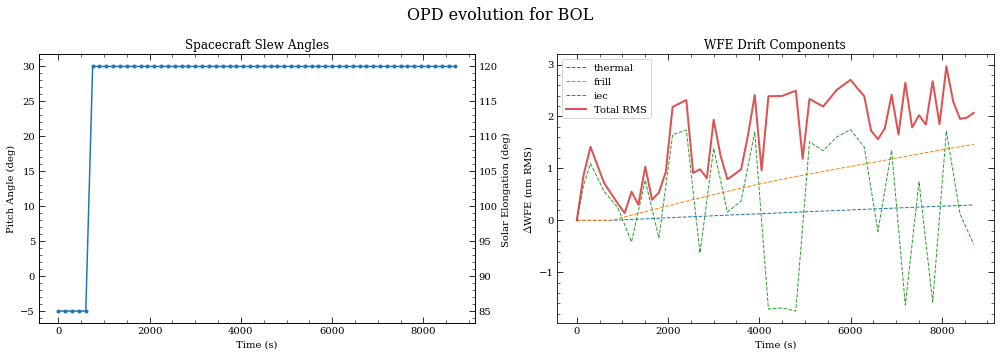

In [22]:
# Plot
fig, axes = plt.subplots(1,2, figsize=(14,5))
axes = axes.flatten()

ax = axes[0]
ax.plot(tarr, slew_angles, marker='.')
ax.set_ylabel('Pitch Angle (deg)')
ax.set_title('Spacecraft Slew Angles')
ax2 = ax.twinx()
ax2.set_ylabel('Solar Elongation (deg)')
ax2.set_ylim(np.array(ax.get_ylim())+90)

ax = axes[1]
keys = list(wfe_dict.keys())
for k in keys:
    lw = 2 if 'total' in k else 1
    ls = '-' if 'total' in k else '--'
    alpha = 0.8 if 'total' in k else 1
    label = 'Total RMS' if 'total' in k else k
    ax.plot(tarr, wfe_dict[k], label=label, lw=lw, ls=ls, alpha=alpha)
ax.legend()

ax.set_ylabel('$\Delta$WFE (nm RMS)')
ax.set_title('WFE Drift Components')

for ax in axes:
    ax.set_xlabel(f'Time ({delta_time.unit})')

fig.suptitle(f'OPD evolution for {case}', fontsize=16)
fig.tight_layout()

In [9]:
# Save all OPDs to HDUList
# Original OPD is added to each delta OPD
# opds_hdul = ote.opds_as_hdul(delta_time, slew_angles, delta_opds=dopds, wfe_dict=wfe_dict, case=case)

# Initialize NIRCam class

In [10]:
# Create a series of PSF coefficients for each time 
from pynrc.psfs import gen_psf_coeff
from copy import deepcopy

outfile = outdir_sim + apname + '_psf_coeff.npz'
if os.path.exists(outfile):
    npzfile = np.load(outfile)
    psf_coeff_all = npzfile['psf_coeff_all']
else:
    psf_kwargs = deepcopy(obs.psf_info)

    psf_kwargs['pupil'] = obs.pupil
    psf_kwargs['mask'] = obs.mask
    psf_kwargs['module'] = obs.module

    psf_kwargs['force'] = True
    psf_kwargs['save'] = False
    psf_kwargs['nproc'] = 4

    detector, detector_position, apname_full = obs._siafap_sci_coords()
    psf_kwargs['detector'] = detector
    psf_kwargs['detector_position'] = detector_position
    psf_kwargs['apname'] = apname_full


    # Generate series of PSF coefficients
    ncf = len(tarr)
    sh_new = [ncf] + list(obs.psf_coeff.shape)
    psf_coeff_all = np.zeros(sh_new, dtype='float')
    for i in trange(ncf):
        # Update OPD inside an HDUList
        opd_hdul = ote.opds_as_hdul(delta_time, slew_angles, delta_opds=dopds, 
                                    wfe_dict=wfe_dict, case=case, return_ind=i)
        psf_kwargs['opd'] = opd_hdul

        res = gen_psf_coeff(obs.filter, **psf_kwargs)
        psf_coeff_all[i] = res[0]

    # Save to disk
    np.savez(outfile, psf_coeff_all=psf_coeff_all)

## Generate series of SEDs

In [11]:
stellar_dict = {'kmag': 6.073, 'sptype': 'M3V', 'Teff': 3318, 'log_g':5.0, 'metallicity':-0.32}

In [12]:
# Read in transit spectra
file = np.load(outdir_sim + 'GJ436b_Trans_SED.npz')
# Actually this is the surface flux, so need to normalize later...
SEDarray = file['SEDarray']          # erg/s/cm^2/A
SEDwave = file['wave']               # Wavelength in mircons
SEDtime = file['time']*24*3400 * u.s # Convert from days to seconds

# Transpose SED array for [nt, nwave]
SEDarray = SEDarray.transpose()

In [13]:
# Re-normalize SED array
bp_k = pynrc.bp_2mass('k')
sp_star = S.ArraySpectrum(SEDwave*1e4, SEDarray[0], fluxunits='flam')
sp_star = sp_star.renorm(stellar_dict['kmag'], 'vegamag', bp_k)

SEDarray = (SEDarray / SEDarray[0]) * sp_star.flux

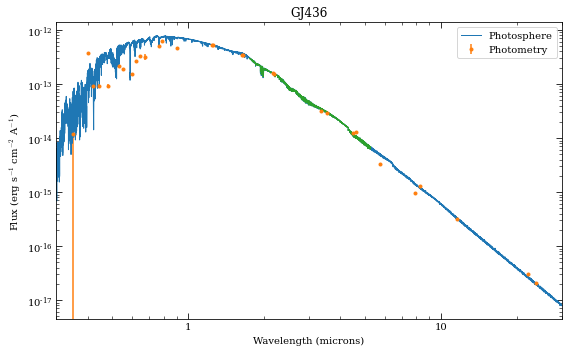

In [16]:
# Option to use BOSZ model instead
votdir = 'votables/'
vot = f'votables/{name_sci}.vot'

bp_k = pynrc.bp_2mass('k')
args = (name_sci, stellar_dict['sptype'], stellar_dict['kmag'], bp_k, vot)
kws = ['Teff', 'metallicity', 'log_g']
kwargs = {}
for k in kws:
    kwargs[k] = stellar_dict[k]
src = nrc_utils.source_spectrum(*args, **kwargs)

# Fit input stellar atmosphere model to observed photometry (optional)
# src.fit_SED(use_err=False, robust=False, wlim=[1,4])

# Bin stellar atmosphere onto common wavelength grid
sp_star = nrc_utils.bin_spectrum(src.sp0, SEDwave)



# Overplot spectrum with photometry to make sure all is consistent
fig, ax = plt.subplots(1,1, figsize=(8,5))

# Plot input and re-binned version
src.plot_SED(ax=ax, units='flam')
ax.semilogy(SEDwave, sp_star.flux, lw=1)

fig.tight_layout()

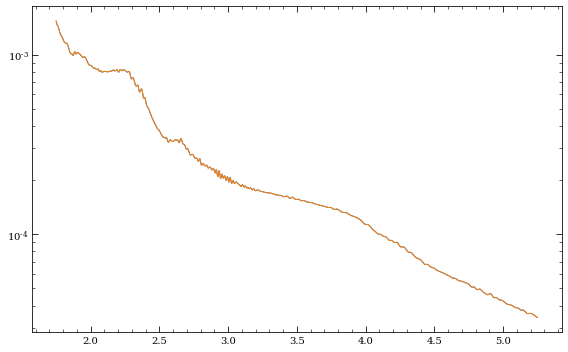

In [14]:
# Compare before and after flux-normalized SEDs
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.semilogy(SEDwave, SEDarray[0] / np.sum(SEDarray[0]), lw=1)
SEDarray = (SEDarray / SEDarray[0]) * sp_star.flux
ax.plot(SEDwave, SEDarray[0] / np.sum(SEDarray[0]), lw=1)

fig.tight_layout()

# Create Slope images for each integration

In [15]:
# Interpolation function to get input SED at any given time
finterp_SED = interp1d(SEDtime, SEDarray, axis=0)

In [16]:
# Get times corresponding to each integration

tstart_oh = 700 # Overhead until start of exposure
dt = obs.multiaccum_times['t_int_tot2'] # Time between integrations (incl. reset time)
nint = obs.multiaccum.nint

# Time locations for each integration
tnew_all = (np.arange(0,nint*dt,dt) + tstart_oh) * u.s

In [17]:
import multiprocessing as mp

def get_slope_helper(args):
    
    # Hack that prevents tqdm warnings
    # print(' ', end='', flush=True)
    
    obs, psf_cf, wave_um, flux_flam = args
        
    # Update PSF coefficients
    obs._psf_coeff = psf_cf
    # Generate dispersed ideal slope image
    sp_new = S.ArraySpectrum(wave_um*1e4, flux_flam, fluxunits='flam')
    wout, im_slope = obs.gen_psf(sp=sp_new)
    return im_slope

In [18]:
outfile = outdir_sim + apname + '_image_slopes.npz'
if os.path.exists(outfile):
    npzfile = np.load(outfile)
    wout         = npzfile['wout'] # Wavelengths associated with each pixel
    im_slope_all = npzfile['im_slope_all']
else:
    # Wavelength array for each pixel
    wout, _ = obs.gen_psf()
    
    nsplit=4

    # For every 100 integrations, make a new series of PSFs
    npsf = 100
    ntime = len(tnew_all)
    niter = int(len(tnew_all) / npsf) + 1
    im_slope_all = []
    for ii in trange(niter):
        tnew = tnew_all[npsf*ii:npsf*(ii+1)]

        # Set of new PSF coefficiencts
        cf_new = ote.interp_dopds(tarr*u.s, psf_coeff_all, tnew)

        # Get absorption spectra for each time step
        SEDflux_new = finterp_SED(tnew)

        total = len(cf_new)
        worker_args = [(obs, cf_new[i], SEDwave, SEDflux_new[i]) for i in range(total)]
        if nsplit>1:
            with mp.Pool(nsplit) as pool:
                for im_slope in tqdm(pool.imap(get_slope_helper, worker_args), 
                                     total=total, leave=False):
                    im_slope_all.append(im_slope)
                pool.close()
        else:
            for args in tqdm(worker_args, leave=False):            
                im_slope = get_slope_helper(args)
                im_slope_all.append(im_slope)

    im_slope_all = np.array(im_slope_all)
    
    # Save to disk
    np.savez(outfile, wout=wout, im_slope_all=im_slope_all)

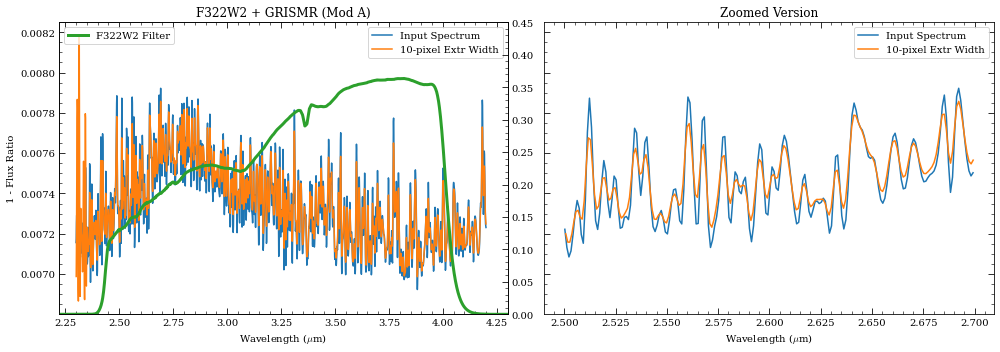

In [19]:
# Sanity check plot to compare extracted exoplanet spectrum to input spectrum

fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=True)

ax = axes[0]
wmin, wmax = (2.3, 4.2) # Min and max wavelengths for plotting

# Input spectra at each time integration time step
fnew_all = finterp_SED(tnew_all)

# Max transit depth position
transit_avg = fnew_all.mean(axis=1) # Average transit depth at each wavelength
transit_avg /= np.max(transit_avg)
itransit = np.where(transit_avg==transit_avg.min())[0]

# Spectrum at max transit
abs_spec = 1 - fnew_all[itransit] / fnew_all[0]

ind = (SEDwave>wmin) & (SEDwave<wmax)
label='Input Spectrum'
ax.plot(SEDwave[ind], abs_spec[0,ind], label=label)
ind = (SEDwave>2.5) & (SEDwave<2.7)
axes[1].plot(SEDwave[ind], abs_spec[0,ind], label=label)

# Slope image extraction
hw_pix = 5
ymid = int(im_slope_all.shape[1] / 2)
y1, y2 = np.array([-1,1])*hw_pix + ymid
spec_all = im_slope_all[:,y1:y2,:].sum(axis=1)
spec_ratio = 1-spec_all[itransit]/spec_all[0]

ind = (wout>wmin) & (wout<wmax)
label=f'{2*hw_pix}-pixel Extr Width'
ax.plot(wout[ind], spec_ratio[0,ind], label=label)
ind = (wout>2.5) & (wout<2.7)
axes[1].plot(wout[ind], spec_ratio[0,ind], label=label)

ax2 = ax.twinx()
obs.plot_bandpass(ax=ax2, lw=3, color='C2')
ax2.set_ylim([0,0.45])
ax2.set_ylabel('')
ax2.legend(loc=2)

ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_ylabel('1 - Flux Ratio')
ax.set_xlim([obs.bandpass.wave.min()/1e4,obs.bandpass.wave.max()/1e4])

ax2.set_title('F322W2 + GRISMR (Mod A)')

for ax in axes:
    ax.set_xlabel('Wavelength ($\mu$m)')
    ax.legend()
axes[1].set_title('Zoomed Version')

fig.tight_layout()

In [20]:
im_sat = obs.saturation_levels(sp_star, ngroup=obs.multiaccum.ngroup, image=im_slope_all[0])
print('Max Saturation Fraction: {:.2f}'.format(im_sat.max()))

Max Saturation Fraction: 0.45


In [21]:
from pynrc.nrc_utils import place_grismr_tso

In [22]:
# Aligned undeviated wavelength with reference positiona
# Slopes are in sci coords
wout, im_slope_all = place_grismr_tso(wout, im_slope_all, obs.siaf_ap)

# Add in Zodiacal background emission

In [25]:
# Add exozodiacal background

# Coordinates of science target
c = SkyCoord.from_name(name_sci)

# Get bg zodiacal image at source location (averaged over observable time period)
bg_image = obs.bg_zodi_image(ra=c.ra.deg, dec=c.dec.deg)

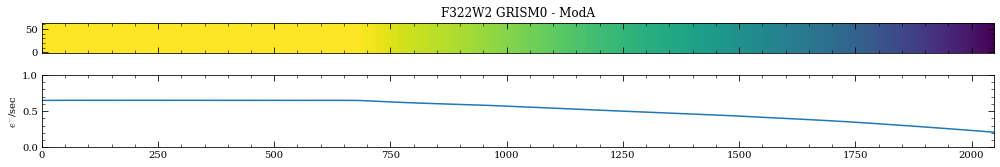

In [26]:
fig, axes = plt.subplots(2,1, figsize=(14,2.5), sharex=True)

ax = axes[0]
ax.imshow(bg_image)
ax.set_title(f'{obs.filter} {obs.pupil} - Mod{obs.module}')

ax = axes[1]
ax.plot(bg_image[10,:])
ax.set_ylim([0,1])
ax.set_ylabel('$e^{-}$/sec')

fig.tight_layout()

In [27]:
# Add to all slope images
# Results are still in sci coords
im_slope_all += bg_image

# Init NIRCam Dark

In [28]:
datadir='/Users/jarron/NIRCam/Data/CV3_Darks/'
outdir='/Users/jarron/NIRCam/dark_analysis/CV3/'
dark_data = nircam_dark(obs.Detectors[0].scaid, datadir, outdir)

In [29]:
# Dark ramp/slope info

# Get Super dark ramp (cube)
dark_data.get_super_dark_ramp()

# Calculate dark slope image
dark_data.get_dark_slope_image()
dark_data.get_super_bias_update()

# Calculate pixel slope averages
dark_data.get_pixel_slope_averages()

# Delete super dark ramp to save memory
del dark_data._super_dark_ramp
dark_data._super_dark_ramp = None

In [30]:
# Calculate CDS Noise for various component 
# white noise, 1/f noise (correlated and independent), temporal and spatial
dark_data.get_cds_dict()

# Effective Noise
dark_data.get_effective_noise()

# Get kTC reset noise, IPC, and PPC values
dark_data.get_ktc_noise()

# Get the power spectrum information
# Saved to pow_spec_dict['freq', 'ps_all', 'ps_corr', 'ps_ucorr']
dark_data.get_power_spectrum(include_oh=False, calc_cds=True, mn_func=np.median, per_pixel=False)

In [31]:
# Calculate IPC/PPC kernels
dark_data.get_ipc(calc_ppc=True)
# Deconvolve the super dark and super bias images
dark_data.deconvolve_supers()

In [32]:
# Get column variations
dark_data.get_column_variations()
# Create dictionary of reference pixel behavior
dark_data.get_ref_pixel_noise()

# Simulate ramp data

In [ ]:
# Convert slope images from sci to det coords
im_slope_all = nrc_utils.sci_to_det(im_slope_all, obs.Detectors[0].detid)

In [8]:
from pynrc.simul.ngNRC import slope_to_ramps

det = obs.Detectors[0]
outfile = outdir_sim + f'{name_sci}_{apname}_DMS.FITS'

if os.path.exists(outfile):
    hdul = fits.open(outfile)
else:
    # This assume all input data is in 'det' coords
    # DMS output will be in 'sci' coords
    hdul = slope_to_ramps(det, dark_data, im_slope=im_slope_all, targ_name=name_sci,
                          filter=obs.filter, pupil=obs.pupil, return_results=True,
                          file_out=outfile, DMS=True)
    
# Slope images no longer needed
try:
    del im_slope_all
except:
    pass

In [9]:
hdul.info()

Filename: /Users/jarron/GitHub/pynrc/notebooks/GTO/Transits/GJ436_GRISMR/GJ436_NRCA5_GRISM64_F322W2_DMS.FITS
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     101   ()      
  1  SCI           1 ImageHDU        13   (2048, 64, 6, 3020)   int16 (rescales to uint16)   
  2  ZEROFRAME     1 ImageHDU        11   (2048, 64, 3020)   int16 (rescales to uint16)   


# Create DMS data model

In [16]:
from pynrc.simul.dms import obs_params_populate, jw_obs_id
from pynrc.simul.dms import create_DMS_HDUList, update_dms_headers

In [11]:
# Science integrations and Zero frame data
sci_data_all = hdul['SCI'].data
zro_data_all = hdul['ZEROFRAME'].data

In [12]:
# Initialize obs dict
obs_params = {}

# Proposal info
obs_params['pi_name']          = 'Thomas Beatty'
obs_params['title']            = 'GJ436 Data Challenge'
obs_params['category']         = 'GO'
obs_params['sub_category']     = 'UNKNOWN'
obs_params['science_category'] = 'Exoplanets and Exoplanet Formation'
obs_params['catalog_name']     = 'Ross 905'

In [13]:
# Static values for all FITS segments within this exposure

# Observation label set in APT file
obs_params['obs_label']    = 'Baseline GRISMR'

# Type of exposure
obs_params['exp_type']     = 'NRC_TSGRISM'
#   NRC_IMAGE, NRC_CORON, NRC_TSIMAGE, NRC_TSGRISM, NRC_WFSS
#   NRC_TACQ, NRC_TACONFIRM, NRC_FOCUS
#   NRC_DARK, NRC_FLAT, NRC_LED, NRC_GRISM

# Dither information
obs_params['primary_type']          = 'NONE'     # Primary dither pattern name
obs_params['position_number']       = 1          # Primary dither position number
obs_params['total_points']          = 1          # Total number of primary dither positions
obs_params['pattern_size']          = 'DEFAULT'  # Primary dither pattern size 
obs_params['subpixel_type']         = 'NONE'     # Subpixel dither pattern name
obs_params['subpixel_number']       = 1          # Subpixel dither position number
obs_params['subpixel_total_points'] = 1          # Total number of subpixel dither positions
obs_params['x_offset']              = 0.0        # Dither pointing offset from starting position in x (arcsec)
obs_params['y_offset']              = 1.449      # Dither pointing offset from starting position in y (arcsec)

In [14]:
# Determine number of segments to break FITS file into
max_size_MB = 320
npix_int = det.xpix * det.ypix * det.multiaccum.nread_tot
int_size_MB = 2 * npix_int / (1024*1024)  # 2 bytes/pix
nint_max = int(max_size_MB / int_size_MB)

# Number of FITS segments to split
nseg = det.multiaccum.nint / nint_max
nseg = int(nseg) if nseg.is_integer() else int(nseg)+1

# Number of ints in each segment
nint_per_seg = det.multiaccum.nint / nseg
nint_per_seg = int(nint_per_seg) if nint_per_seg.is_integer() else int(nint_per_seg)+1

# Built integer indices
iseg1 = np.arange(nseg)*nint_per_seg
iseg2 = iseg1 + nint_per_seg
iseg2[-1] = det.multiaccum.nint
iseg_list = [(i1,i2) for i1,i2 in zip(iseg1,iseg2)]

print(nseg, nint_per_seg)

15 202


In [17]:
# Start of observation and relative exposure start offset
date_obs = '2023-01-01'
time_obs = '12:00:00.000'
time_exp_offset = 2700  # seconds

# PA V3 roll position
pa_v3 = 300

# Generate observation information
# (pid, obs num, visit num, visit gp, seq id, activity id, exp_num)
obs_id_info = jw_obs_id(4242,1,1, 1,1,1, 2)

for ii in trange(nseg):
    i1, i2 = iseg_list[ii]
    segNum = ii+1

    pseg = obs_params_populate(obs, name_sci, date_obs, time_obs, pa_v3, 
                               time_exp_offset=time_exp_offset, 
                               segNum=segNum, int_range=(i1,i2),
                               obs_id_info=obs_id_info, **obs_params)
    
    # Generate model
    sci_data = sci_data_all[i1:i2]
    zero_data = zro_data_all[i1:i2]
    obsModel = create_DMS_HDUList(sci_data, zero_data, pseg)

    # Save to FITS file
    file_path = os.path.join(outdir_sim, pseg['filename'])
    obsModel.save(file_path)
    
    # Minor updates to the saved FITS file
    update_dms_headers(file_path)
